In [1]:
import numpy as np
import pandas as pd
#from IPython.display import display, HTML, Image, Javascript, Markdown, SVG
from scipy.stats import norm, pearsonr
import plotly.express as px
from sklearn.metrics import accuracy_score,  cohen_kappa_score
from scipy.stats import spearmanr

C:\Users\jichen\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#pip install --upgrade --user pandas

In [3]:
def compute_agreement(array1, array2):
    exact_agreement = 0
    adjacent_agreement = 0
    discrepancy = 0

    n = len(array1)
    for i in range(n - 1):
        # Exact Agreement
        if array1[i] == array2[i]:
            exact_agreement += 1

        # Adjacent Agreement
        if abs(array1[i] - array2[i]) == 1:
            adjacent_agreement += 1

        # Discrepancy
        if abs(array1[i] - array2[i])>=2:
            discrepancy += 1

    # Calculate percentages
    exact_agreement_pct = exact_agreement / n * 100
    adjacent_agreement_pct = adjacent_agreement / n * 100
    discrepancy_pct = discrepancy / n * 100
    
    # Compute Linear Weighted Kappa
    linear_weighted_kappa = cohen_kappa_score(array1, array2, weights='linear')
    quadratic_weighted_kappa = cohen_kappa_score(array1, array2, weights='quadratic')

    return exact_agreement_pct, adjacent_agreement_pct, discrepancy_pct, linear_weighted_kappa, quadratic_weighted_kappa

In [4]:
def generate_discrete_data_agreement(rho,n,ptile1,ptile2,ptile3):
    mean = (0, 0)
    cov = [[1, rho], [rho, 1]]
    v = np.random.multivariate_normal(mean, cov, (n))
    x = v[:,0]
    y = v[:,1]
    x_cut1 = np.percentile(x,ptile1)
    x_cut2 = np.percentile(x,ptile2)
    x_cut3 = np.percentile(x,ptile3)
    x[x < x_cut1]=1
    x[(x >= x_cut1)*(x < x_cut2)*(x !=1)] = 2
    x[(x >= x_cut2)*(x < x_cut3)*(x !=1)*(x !=2)] = 3
    x[(x >= x_cut3)*(x !=1)*(x !=2)*(x!=3)] = 4
    
    y_cut1 = np.percentile(y,ptile1)
    y_cut2 = np.percentile(y,ptile2)
    y_cut3 = np.percentile(y,ptile3)
    
    z = np.empty(n)
    z[y < y_cut1] = 1
    z[(y >= y_cut1)*(y < y_cut2)*(y !=1)] = 2
    z[(y >= y_cut2)*(y < y_cut3)*(y !=1)*(y !=2)] = 3
    z[(y >= y_cut3)*(y !=1)*(y !=2)*(y!=3)] = 4
    
    #rho_out = pearsonr(x,y)[0] 
    # df = pd.DataFrame([x,y]).T
    # df.columns=['ALDs','difficulty_parameter']
    # fig = px.scatter(df,x='ALDs',y='difficulty_parameter',marginal_y='histogram',color='ALDs'\
    #                ,trendline='ols',title='Correlation: '+str(rho_out)[0:4])
    # fig.update_layout(width=800, height=500)
    # fig.show()
    
    df = pd.DataFrame([x,y]).T
    df.columns=['ALDs','difficulty_parameter']
    exact_pct, adjacent_pct, discrepancy_pct, linear_kappa, quadratic_kappa = compute_agreement(x, z)
    return (df, exact_pct, adjacent_pct, discrepancy_pct, linear_kappa, quadratic_kappa)

In [5]:
generate_discrete_data_agreement(0.7,1000,25,50,75)[5]

0.6288

# 1. Correlational Upper Bound under Perfect Alignment

In [7]:
data = {
    'P1': [25, 15, 30, 5],
    'P2': [50, 50, 60, 20],
    'P3': [75, 85, 90, 70]
}

dis = pd.DataFrame(data)

In [8]:
dis

,P1,P2,P3
0,25,50,75
1,15,50,85
2,30,60,90
3,5,20,70


In [12]:
per_cor_table = []
dist_names = ['uniform','non-uniform-bal','skewed-A','skewed-B']
for i, dist_name in enumerate (dist_names): 
    for j in range(10):
        np.random.seed(j)
        df = generate_discrete_data_agreement(1, 1000, dis['P1'][i], dis['P2'][i],dis['P3'][i])[0]
        correlation = df.corr().iloc[0,1]
        per_cor_table.append((dist_name, j, correlation))  

In [13]:
per_cor_table = pd.DataFrame(per_cor_table).rename(columns = {0:'distribution',1:'iter',2:'correlation'})
round(per_cor_table.groupby('distribution').correlation.mean(),2)

distribution
non-uniform-bal    0.94
skewed-A           0.93
skewed-B           0.91
uniform            0.92
Name: correlation, dtype: float64

# 2. ESS Count based cuts

In [11]:
def optimal_cut (data,ptile,level_number):# ptile is the percentile for the distribution,
    # e.g. ptile = 25 for the first cut of the uniform distribution
    # e.g. level_number = '12' for the first cut of the distribution
    if ptile - 10 < 0:
        ptile_minus10 = 0
    else:
        ptile_minus10 = ptile - 10
    cut_range_low = round(np.percentile(data.difficulty_parameter,ptile_minus10),1)  # Starting number

    if ptile + 10 > 100:
        ptile_add10 = 100
    else:
        ptile_add10 = ptile + 10
    cut_range_high = round(np.percentile(data.difficulty_parameter,ptile_add10),1)  # Ending number
    
    accuracy_table = []
    #----------------------
    step_size = 0.01  # Desired step size between values
    cut_values = np.arange(cut_range_low, cut_range_high, step_size)
    cut_values = np.round(cut_values,2)
    for cut in cut_values:
        data.loc[data.difficulty_parameter < cut,'level'+level_number] = 'low'
        data.loc[data.difficulty_parameter >= cut,'level'+level_number] = 'high'
        accuracy_table.append((cut,accuracy_score(data['ALD'+level_number], data['level'+level_number])))
    accuracy_table = pd.DataFrame(accuracy_table).rename(columns = {0:'Cut',1:'accuracy'}) # accuracy table for all cuts
    accuracy_max = accuracy_table.loc[accuracy_table.accuracy == accuracy_table.accuracy.max(),:] # find out the max accuracy
    optimal_cutoff = round(accuracy_max.Cut.mean(),2)
    return (optimal_cutoff)

In [14]:
method = 'ESS_Counts'
def cal_agreement(rho,n,ptile1,ptile2,ptile3):
    cut_table = []
    agreement_table = []
    percent_table = []
    for i in range(10): 
        np.random.seed(i)
        df = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[0] # change as correlation level change
        true_exa = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[1]
        true_adj = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[2]
        true_dis = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[3]
        true_lkap = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[4]
        true_qkap = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[5]
        
        df.loc[df.ALDs ==1, 'ALD12'] = 'low' # recode ALDs to low or high for each ALD cut
        df.loc[df.ALDs > 1, 'ALD12'] = 'high'
        df.loc[df.ALDs <=2, 'ALD23'] = 'low'
        df.loc[df.ALDs > 2, 'ALD23'] = 'high'
        df.loc[df.ALDs <=3, 'ALD34'] = 'low'
        df.loc[df.ALDs > 3, 'ALD34'] = 'high'
        #------------------
        ptile_cut1 = round(np.percentile(df.difficulty_parameter,ptile1),2)
        ptile_cut2 = round(np.percentile(df.difficulty_parameter,ptile2),2)
        ptile_cut3 = round(np.percentile(df.difficulty_parameter,ptile3),2)
        #print(ptile_cut1,ptile_cut2,ptile_cut3)
        #----------------------------------
        cut1 = optimal_cut(df,ptile1,'12') # change as number of categories change
        cut2 = optimal_cut(df,ptile2,'23') # change as number of categories change
        cut3 = optimal_cut(df,ptile3,'34') # change as number of categories change

        #---------------------------
        df.loc[(df.difficulty_parameter<cut1),'ALDs_pred'] = 1
        df.loc[(df.difficulty_parameter>=cut1) & (df.difficulty_parameter<cut2),'ALDs_pred'] = 2
        df.loc[(df.difficulty_parameter>=cut2) & (df.difficulty_parameter<cut3),'ALDs_pred'] = 3
        df.loc[(df.difficulty_parameter>=cut3),'ALDs_pred'] = 4
        
        #---generate crosstab tables------------------
        crosstab_table = (pd.crosstab(df['ALDs'],df['ALDs_pred'],margins=True, margins_name='Total')/10).reset_index()

        # Calculate exact agreement
        exact_agreement = round(len(df.loc[df.ALDs == df.ALDs_pred,:])/ len(df)*100,1)

        # Calculate adjacent agreement
        adjacent_agreement = round(np.sum(np.abs(df['ALDs'] - df['ALDs_pred']) == 1) / len(df)*100,1)

        # Calculate discrepant 
        discrepant = round(np.sum(np.abs(df['ALDs'] - df['ALDs_pred']) > 1)/len(df)*100,1)

        # Calculate linear-weighted quadratic kappa
        Lkappa = round(cohen_kappa_score(df['ALDs'], df['ALDs_pred'], weights='linear'),3)
        Qkappa = round(cohen_kappa_score(df['ALDs'], df['ALDs_pred'], weights='quadratic'),3)
        

        # correlation
        r = round(spearmanr(df['ALDs'], df['difficulty_parameter'])[0],3)
        n1 = round(len(df.loc[df.ALDs_pred==1,:])/1000*100,1)
        n2 = round(len(df.loc[df.ALDs_pred==2,:])/1000*100,1)
        n3 = round(len(df.loc[df.ALDs_pred==3,:])/1000*100,1)
        n4 = round(len(df.loc[df.ALDs_pred==4,:])/1000*100,1)

        cut_table.append((rho,r, ptile1,ptile2,ptile3,i, ptile_cut1, ptile_cut2, ptile_cut3, cut1, cut2, cut3))
        agreement_table.append((rho,r, ptile1,ptile2,ptile3,i,exact_agreement,true_exa, exact_agreement-true_exa,\
                                adjacent_agreement,true_adj,adjacent_agreement-true_adj,\
                                discrepant,true_dis, discrepant-true_dis,\
                                Lkappa,true_lkap,Lkappa-true_lkap,\
                                Qkappa,true_qkap,Qkappa-true_qkap))
        percent_table.append((rho,r,i, ptile1, ptile2-ptile1,ptile3-ptile2,100-ptile3,n1,n2,n3,n4))
        
    cut_table = pd.DataFrame(cut_table).rename(columns = {0:'rho',1:'correlation',2:'ptile1',3:'ptile2',4:'ptile3',\
                                                  5:'iter',6:'true_cut1', 7:'true_cut2',8: 'true_cut3',9:'cut1',\
                                                          10:'cut2',11: 'cut3'})
    cut_table['Dif_cut1'] = cut_table['cut1'] - cut_table['true_cut1']
    cut_table['Dif_cut2'] = cut_table['cut2'] - cut_table['true_cut2']
    cut_table['Dif_cut3'] = cut_table['cut3'] - cut_table['true_cut3']
    cut_table = cut_table[['rho','correlation','ptile1','ptile2','ptile3','iter','true_cut1','true_cut2','true_cut3',\
                           'cut1','cut2','cut3','Dif_cut1','Dif_cut2','Dif_cut3']]
    
    agreement_table = pd.DataFrame(agreement_table).rename(columns = {0:'rho',1:'correlation',2:'ptile1',3:'ptile2',\
                                                                      4:'ptile3',5:'iter',6:'exa',7:'true_exa', 8:'dif_exa',\
                                                                      9:'adj',10:'true_adj',11:'dif_adj',\
                                                                      12:'dis',13:'true_dis',14:'dif_dis',\
                                                                      15:'lkappa',16:'true_lkappa',17:'dif_lk',\
                                                                      18:'qkappa',19:'true_qkappa',20:'dif_qk'})
    percent_table = pd.DataFrame(percent_table).rename(columns = {0:'rho',1:'correlation',2:'iter',3:'per_L1',4:'per_L2',\
                                                                      5:'per_L3',6:'per_L4',7:'L1',8:'L2',\
                                                                  9:'L3',10:'L4'})

    return (cut_table, agreement_table, percent_table, crosstab_table)

In [41]:
#cal_agreement(0.8,1000,25,50,75)[1]

# 3. Mean Score of Each Score Category, then Midpoint of the Mean Scores (e.g., (mean1+mean2)/2) is the cut

In [25]:
method = 'ESS_Counts_Mean'
def cal_agreement(rho,n,ptile1,ptile2,ptile3):
    cut_table = []
    agreement_table = []
    percent_table = []
    for i in range(10):
        np.random.seed(i)
        df = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[0] # change as correlation level change
        true_exa = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[1]
        true_adj = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[2]
        true_dis = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[3]
        true_lkap = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[4]
        true_qkap = generate_discrete_data_agreement(rho, n, ptile1, ptile2, ptile3)[5]
        
        #------------------
        ptile_cut1 = round(np.percentile(df.difficulty_parameter,ptile1),2)
        ptile_cut2 = round(np.percentile(df.difficulty_parameter,ptile2),2)
        ptile_cut3 = round(np.percentile(df.difficulty_parameter,ptile3),2)
        #print(ptile_cut1,ptile_cut2,ptile_cut3)
        #----------------------------------
        mean1 = df.loc[df.ALDs == 1,'difficulty_parameter'].mean() # change as number of categories change
        mean2 = df.loc[df.ALDs == 2,'difficulty_parameter'].mean()# change as number of categories change
        mean3 = df.loc[df.ALDs == 3,'difficulty_parameter'].mean()# change as number of categories change
        mean4 = df.loc[df.ALDs == 4,'difficulty_parameter'].mean() # change as number of categories change

        cut1 = round((mean1+mean2)/2,2)
        cut2 = round((mean2+mean3)/2,2)
        cut3 = round((mean3+mean4)/2,2)

        #---------------------------
        df.loc[(df.difficulty_parameter<cut1),'ALDs_pred'] = 1
        df.loc[(df.difficulty_parameter>=cut1) & (df.difficulty_parameter<cut2),'ALDs_pred'] = 2
        df.loc[(df.difficulty_parameter>=cut2) & (df.difficulty_parameter<cut3),'ALDs_pred'] = 3
        df.loc[(df.difficulty_parameter>=cut3),'ALDs_pred'] = 4
        
        #---generate crosstab tables------------------
        crosstab_table = (pd.crosstab(df['ALDs'],df['ALDs_pred'],margins=True, margins_name='Total')/10).reset_index()

        # Calculate exact agreement
        exact_agreement = round(len(df.loc[df.ALDs == df.ALDs_pred,:])/ len(df)*100,1)

        # Calculate adjacent agreement
        adjacent_agreement = round(np.sum(np.abs(df['ALDs'] - df['ALDs_pred']) == 1) / len(df)*100,1)

        # Calculate discrepant 
        discrepant = round(np.sum(np.abs(df['ALDs'] - df['ALDs_pred']) > 1)/len(df)*100,1)

        # Calculate linear-weighted quadratic kappa
        Lkappa = round(cohen_kappa_score(df['ALDs'], df['ALDs_pred'], weights='linear'),3)
        Qkappa = round(cohen_kappa_score(df['ALDs'], df['ALDs_pred'], weights='quadratic'),3)

        # correlation
        #r = round(pearsonr(df['ALDs'],df['difficulty_parameter'])[0],3)
        r = round(spearmanr(df['ALDs'], df['difficulty_parameter'])[0],3)
        n1 = round(len(df.loc[df.ALDs_pred==1,:])/1000*100,1)
        n2 = round(len(df.loc[df.ALDs_pred==2,:])/1000*100,1)
        n3 = round(len(df.loc[df.ALDs_pred==3,:])/1000*100,1)
        n4 = round(len(df.loc[df.ALDs_pred==4,:])/1000*100,1)

        cut_table.append((rho,r, ptile1,ptile2,ptile3,i, ptile_cut1, ptile_cut2, ptile_cut3, cut1, cut2, cut3))
        agreement_table.append((rho,r, ptile1,ptile2,ptile3,i,exact_agreement,true_exa, exact_agreement-true_exa,\
                                adjacent_agreement,true_adj,adjacent_agreement-true_adj,\
                                discrepant,true_dis, discrepant-true_dis,\
                                Lkappa,true_lkap,Lkappa-true_lkap,\
                                Qkappa,true_qkap,Qkappa-true_qkap))
        
        percent_table.append((rho,r,i, ptile1, ptile2-ptile1,ptile3-ptile2,100-ptile3,n1,n2,n3,n4))
        
    cut_table = pd.DataFrame(cut_table).rename(columns = {0:'rho',1:'correlation',2:'ptile1',3:'ptile2',4:'ptile3',\
                                                  5:'iter',6:'true_cut1', 7:'true_cut2',8: 'true_cut3',9:'cut1',\
                                                          10:'cut2',11: 'cut3'})
    cut_table['Dif_cut1'] = cut_table['cut1'] - cut_table['true_cut1']
    cut_table['Dif_cut2'] = cut_table['cut2'] - cut_table['true_cut2']
    cut_table['Dif_cut3'] = cut_table['cut3'] - cut_table['true_cut3']
    cut_table = cut_table[['rho','correlation','ptile1','ptile2','ptile3','iter','true_cut1','true_cut2','true_cut3',\
                           'cut1','cut2','cut3','Dif_cut1','Dif_cut2','Dif_cut3']]
    
    agreement_table = pd.DataFrame(agreement_table).rename(columns = {0:'rho',1:'correlation',2:'ptile1',3:'ptile2',\
                                                                      4:'ptile3',5:'iter',6:'exa',7:'true_exa', 8:'dif_exa',\
                                                                      9:'adj',10:'true_adj',11:'dif_adj',\
                                                                      12:'dis',13:'true_dis',14:'dif_dis',\
                                                                      15:'lkappa',16:'true_lkappa',17:'dif_lk',\
                                                                      18:'qkappa',19:'true_qkappa',20:'dif_qk'})
    percent_table = pd.DataFrame(percent_table).rename(columns = {0:'rho',1:'correlation',2:'iter',3:'per_L1',4:'per_L2',\
                                                                      5:'per_L3',6:'per_L4',7:'L1',8:'L2',\
                                                                  9:'L3',10:'L4'})
    
    return (cut_table, agreement_table, percent_table, crosstab_table)

# 4 Generate results based on Distributions

In [26]:
cor_levels = [0.3,0.55,0.80]
data = {
    'P1': [25, 15, 30, 5],
    'P2': [50, 50, 60, 20],
    'P3': [75, 85, 90, 70]
    
}

dis = pd.DataFrame(data)

cut_tables = pd.DataFrame()
agreement_tables = pd.DataFrame()
crosstab_tables = pd.DataFrame()
percent_tables = pd.DataFrame()
for cor in cor_levels:
    if cor == 0.3:
        cor_level_name = 'low'
    elif cor == 0.55:
        cor_level_name = 'medium'
    elif cor == 0.8:
        cor_level_name = 'high'
        
    for i in range(4):
        p1 = dis['P1'][i]
        p2 = dis['P2'][i]
        p3 = dis['P3'][i]
        if i == 0:
            distribution = 'uniform'
        elif i == 1:
            distribution = 'non-uni-balanced'
        elif i == 2:
            distribution = 'skewed-A'
        elif i == 3:
            distribution = 'skewed-B'

        cut_table = cal_agreement(cor,1000,p1,p2,p3)[0]
        cut_table['dist'] = distribution
        cut_table['corr'] = cor_level_name
        cut_tables = pd.concat([cut_tables,cut_table], axis = 0)
        #----------------
        agreement_table = cal_agreement(cor,1000,p1,p2,p3)[1]
        agreement_table['dist'] = distribution
        agreement_table['corr'] = cor_level_name
        agreement_tables = pd.concat([agreement_tables,agreement_table], axis = 0)        
        #-------------------------------
        percent_table = cal_agreement(cor,1000,p1,p2,p3)[2]
        percent_table['dist'] = distribution
        percent_table['corr'] = cor_level_name        
        percent_tables = pd.concat([percent_tables,percent_table],axis = 0)
        #----------------------------------
        crosstab_table = cal_agreement(cor,1000,p1,p2,p3)[3]
        crosstab_table['dist'] = distribution
        crosstab_table['corr'] = cor_level_name        
        crosstab_tables = pd.concat([crosstab_tables,crosstab_table],axis = 0)

## a. Agreement Table

In [17]:
# Define the pre-specified order
specified_order_dist = ['uniform', 'non-uni-balanced', 'skewed-A','skewed-B']
specified_order_corr = ['high','medium','low']

In [58]:
agreement_table = agreement_tables.groupby(['dist','corr']).mean()
agreement_table = agreement_table.reset_index()
# Convert the column 'dist' to categorical with specified order
agreement_table['dist'] = pd.Categorical(agreement_table['dist'], categories=specified_order_dist, ordered=True)
agreement_table['corr'] = pd.Categorical(agreement_table['corr'], categories=specified_order_corr, ordered=True)
# Sort the DataFrame by the 'dist' column
agreement_table = agreement_table.sort_values(by=['dist','corr'])

In [59]:
agreement_table.round(2).to_excel(r'C:\Users\jichen\Documents\Cambium\ESS_criteria\2024' + '\\'+method+'\\agreement_'+method+'.xlsx',index = False)

## b. Percent Table

In [27]:
percent_table = percent_tables.groupby(['dist','corr']).mean()
percent_table = percent_table.reset_index()
# Convert the column 'dist' to categorical with specified order
percent_table['dist'] = pd.Categorical(percent_table['dist'], categories=specified_order_dist, ordered=True)
percent_table['corr'] = pd.Categorical(percent_table['corr'], categories=specified_order_corr, ordered=True)
# Sort the DataFrame by the 'dist' column
percent_table = percent_table.sort_values(by=['dist','corr'])
percent_table = percent_table.round(1)
percent_table['Dif_L1'] = abs(percent_table['per_L1']-percent_table['L1'])
percent_table['Dif_L2'] = abs(percent_table['per_L2']-percent_table['L2']) 
percent_table['Dif_L3'] = abs(percent_table['per_L3']-percent_table['L3']) 
percent_table['Dif_L4'] = abs(percent_table['per_L4']-percent_table['L4']) 

percent_table.to_excel(r'C:\Users\jichen\Documents\Cambium\ESS_criteria\2024' + '\\'+method+'\\percentage_'+method\
                                +'_checking.xlsx',index = False)

In [28]:
percent_table

,dist,corr,rho,correlation,iter,per_L1,per_L2,per_L3,per_L4,L1,L2,L3,L4,Dif_L1,Dif_L2,Dif_L3,Dif_L4
9,uniform,high,0.8,0.8,4.5,25.0,25.0,25.0,25.0,26.2,23.3,24.7,25.8,1.2,1.7,0.3,0.8
11,uniform,medium,0.6,0.5,4.5,25.0,25.0,25.0,25.0,32.9,17.0,16.8,33.2,7.9,8.0,8.2,8.2
10,uniform,low,0.3,0.3,4.5,25.0,25.0,25.0,25.0,40.7,8.9,9.4,41.0,15.7,16.1,15.6,16.0
0,non-uni-balanced,high,0.8,0.7,4.5,15.0,35.0,35.0,15.0,20.5,28.8,30.0,20.7,5.5,6.2,5.0,5.7
2,non-uni-balanced,medium,0.6,0.5,4.5,15.0,35.0,35.0,15.0,29.2,20.7,20.8,29.4,14.2,14.3,14.2,14.4
1,non-uni-balanced,low,0.3,0.3,4.5,15.0,35.0,35.0,15.0,38.3,11.3,11.7,38.7,23.3,23.7,23.3,23.7
3,skewed-A,high,0.8,0.7,4.5,30.0,30.0,30.0,10.0,30.3,28.6,24.7,16.4,0.3,1.4,5.3,6.4
5,skewed-A,medium,0.6,0.5,4.5,30.0,30.0,30.0,10.0,35.7,20.0,19.4,24.9,5.7,10.0,10.6,14.9
4,skewed-A,low,0.3,0.3,4.5,30.0,30.0,30.0,10.0,42.3,10.9,11.0,35.8,12.3,19.1,19.0,25.8
6,skewed-B,high,0.8,0.7,4.5,5.0,15.0,50.0,30.0,10.0,20.0,35.8,34.2,5.0,5.0,14.2,4.2


## c. Cut Table

In [175]:
cut_table = cut_tables.groupby([ 'dist','corr']).mean()
cut_table = cut_table.reset_index()

# Convert the column 'dist' to categorical with specified order
cut_table['dist'] = pd.Categorical(cut_table['dist'], categories=specified_order_dist, ordered=True)
cut_table['corr'] = pd.Categorical(cut_table['corr'], categories=specified_order_corr, ordered=True)
# Sort the DataFrame by the 'dist' column
cut_table = cut_table.sort_values(by=['dist','corr'])

In [176]:
cut_table.round(2).to_excel(r'C:\Users\jichen\Documents\Cambium\ESS_criteria\2024' + '\\'+method+'\\cut_table_'+\
                            method+'_Full.xlsx',index = False)

In [177]:
cut_tables.to_csv(r'C:\Users\jichen\Documents\Cambium\ESS_criteria\2024' + '\\'+method+'\\cut_table_'+\
                            method+'_by_iterations.csv',index = False)

In [155]:
def gen_bootstrap_means(df, sample_size = 10, n_samples =1000): # n_samples is the number of bootstrap samples, 
    #sample_size is the sample size of each sample
    # Array to store bootstrap means
    bootstrap_means = np.zeros(n_samples)
    # Bootstrap resampling
    for i in range(n_samples):
        # Generate bootstrap sample
        bootstrap_sample = np.random.choice(df, size = sample_size, replace=True)
        # Calculate mean of bootstrap sample
        bootstrap_means[i] = np.mean(bootstrap_sample)
    return bootstrap_means

# Method 2 Calculate the confidence interval
# std = np.std(bootstrap_means, ddof=1)
# mean = np.mean(bootstrap_means)
# margin_of_error = std / np.sqrt(n) * np.abs(norm.ppf((1 - confidence_level) / 2))
# ci_low = mean - margin_of_error
# ci_up = mean + margin_of_error
# confidence_interval = [ci_low, ci_up]

# print("Bootstrap Confidence Interval (95%):", confidence_interval_cut)

In [165]:
cuts = cut_tables.loc[(cut_tables.dist == 'non-uni-balanced') & (cut_tables['corr'] =='high'),:].cut1
tcuts = cut_tables.loc[(cut_tables.dist == 'non-uni-balanced') & (cut_tables['corr'] =='high'),:].true_cut1
sample_size = 10
n_samples = 1000

def ci_overlap(cuts, tcuts): 
    confidence_interval_cut = np.percentile(gen_bootstrap_means(cuts,sample_size,n_samples), [2.5, 97.5])
    confidence_interval_tcut = np.percentile(gen_bootstrap_means(tcuts,sample_size,n_samples), [2.5, 97.5])
    max_L = max(confidence_interval_cut[0],confidence_interval_tcut[0])
    min_U = min(confidence_interval_cut[1],confidence_interval_tcut[1])
    if max_L > min_U:
        overlap = 0
    else:
        overlap = min_U - max_L
    print("Bootstrap Confidence Interval (95%):", confidence_interval_cut)
    print("Bootstrap Confidence Interval (95%):", confidence_interval_tcut)
    return overlap

In [166]:
ci_overlap(cuts,tcuts)

Bootstrap Confidence Interval (95%): [-1.412    -1.214975]
Bootstrap Confidence Interval (95%): [-1.063 -1.014]


0

In [154]:
overlap

0

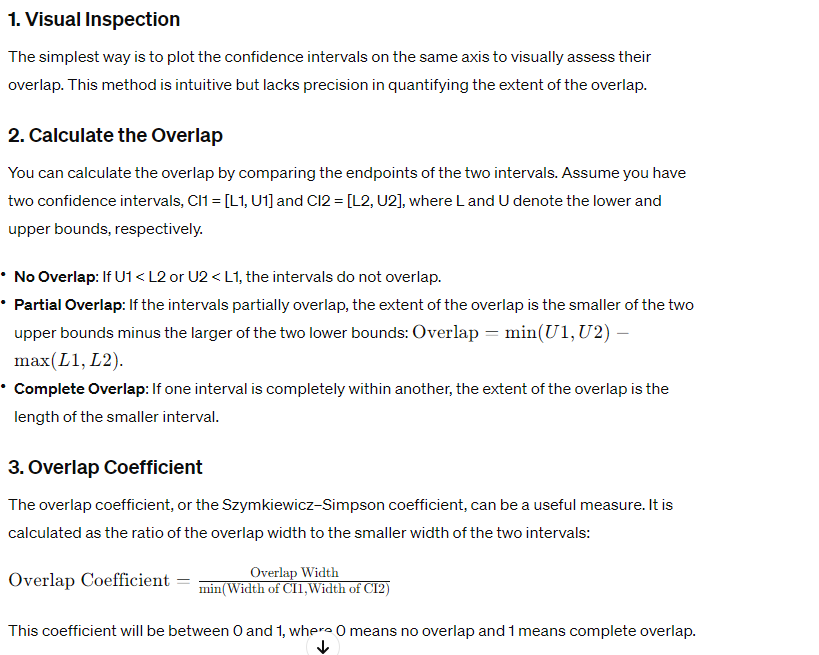

In [ ]:
def rel_table(df_list): 
    table = []
    for df_i in df_list:
        marg = (df_i.thetaScore.var()-((df_i.thetaSE)**2).mean())/df_i.thetaScore.var()
        table.append((df_i.name,marg))
    table = pd.DataFrame(table).rename(columns={0:'test',1:'marginal reliability'})
    return (table)

In [124]:
from openpyxl import Workbook
from openpyxl.styles import Font


# Create a new Excel workbook and select the active sheet
wb = Workbook()
ws = wb.active

            
# Write DataFrame to Excel
for r_idx, row in enumerate(cut_table.itertuples(), start=1):
    for c_idx, value in enumerate(row[1:], start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)
        # Apply red font color to numbers less than 0, starting from the third column
        if c_idx >14 and (value < -0.25 or value> 0.25):
            ws.cell(row=r_idx, column=c_idx).font = Font(color="FF0000")


# Save the workbook
wb.save(r'C:\Users\jichen\Documents\Cambium\ESS_criteria\2024' + '\\'+method+'\\cut_table_'+method+'_highlighted.xlsx')

In [125]:
wb

## d. Crosstab tables

In [126]:
crosstab_mean = crosstab_tables.groupby(['dist','corr','ALDs']).mean().reset_index()
pivot_table = crosstab_mean.pivot_table(index=['dist', 'ALDs'], columns='corr').reset_index()
# Define the pre-specified order
specified_order = ['uniform', 'non-uni-balanced', 'skewed-A','skewed-B', 'skewed-C', 'skewed-D']

# Convert the column 'dist' to categorical with specified order
pivot_table['dist'] = pd.Categorical(pivot_table['dist'], categories=specified_order, ordered=True)

# Sort the DataFrame by the 'dist' column
pivot_table = pivot_table.sort_values(by=['dist','ALDs'])
# # Rename the columns to include 'corr' information
pivot_table.columns = ['{}_{}'.format(col[1], col[0]) for col in pivot_table.columns]

# Sort the columns
#sorted_columns = sorted(pivot_table.columns, key=lambda x: (x.split('_')[0], x.split('_')[1]))
sorted_columns = ['_dist','_ALDs','high_1.0','high_2.0','high_3.0','high_4.0','high_Total',
 'medium_1.0','medium_2.0','medium_3.0','medium_4.0','medium_Total', 
'low_1.0','low_2.0','low_3.0','low_4.0','low_Total']
pivot_table = pivot_table[sorted_columns]
pivot_table.to_excel(r'C:\Users\jichen\Documents\Cambium\ESS_criteria\2024' + '\\'+method+'\\crosstab_'+\
                     method+'.xlsx',index = False)

# ESS weight based cuts

In [5]:
def optimal_cut_wei (data,ptile, level_number):# ptile is the percentile for the distribution,
    # e.g. ptile = 25 for the first cut of the uniform distribution
    # e.g. level_number = '12' for the first cut of the distribution    
    if ptile - 10 < 0:
        ptile_minus10 = 0
    else:
        ptile_minus10 = ptile - 10
    cut_range_low = round(np.percentile(data.difficulty_parameter,ptile_minus10),1)  # Starting number

    if ptile + 10 > 100:
        ptile_add10 = 100
    else:
        ptile_add10 = ptile + 10
    cut_range_high = round(np.percentile(data.difficulty_parameter,ptile_add10),1)  # Ending number
    
    accuracy_table = []
    #----------------------
    step_size = 0.01  # Desired step size between values
    cut_values = np.arange(cut_range_low, cut_range_high, step_size)
    cut_values = np.round(cut_values,2)
    for cut in cut_values:
        data.loc[data.difficulty_parameter < cut,'level'+level_number] = 'low'
        data.loc[data.difficulty_parameter >= cut,'level'+level_number] = 'high'
        inconsis = data.loc[data['ALD'+level_number] != data['level'+level_number],:]
        accuracy_table.append((cut,abs(inconsis['difficulty_parameter'] - cut).sum())) # find out the abs D for all cases
    accuracy_table = pd.DataFrame(accuracy_table).rename(columns = {0:'Cut',1:'D'}) # accuracy table for all cuts
    accuracy_max = accuracy_table.loc[accuracy_table.D == accuracy_table.D.min(),:] # find out the max accuracy
    optimal_cutoff = round(accuracy_max.Cut.mean(),2)
    return (optimal_cutoff)